Error loading data: [Errno 2] No such file or directory: '/Users/santoshreddy/Desktop/diabetes.csv'
Creating a sample dataset for demonstration...
Sample dataset created with shape: (8, 9)

Sample data:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Preprocessing completed. Train set shape: (6, 8), Test set shape: (2, 8)
Training and evaluating mod

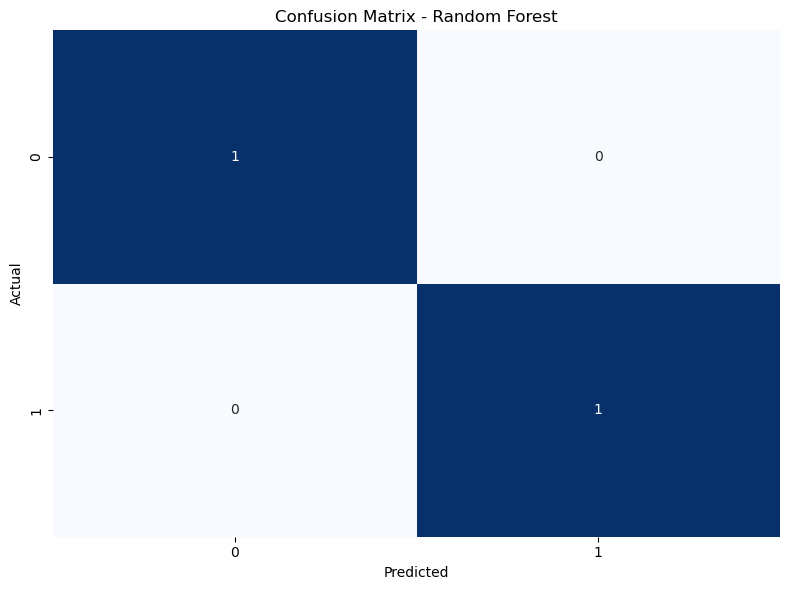

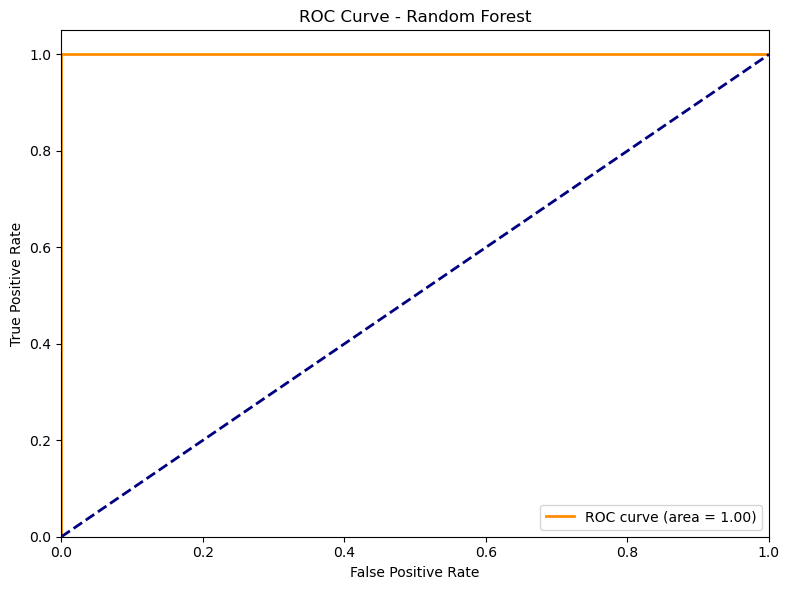

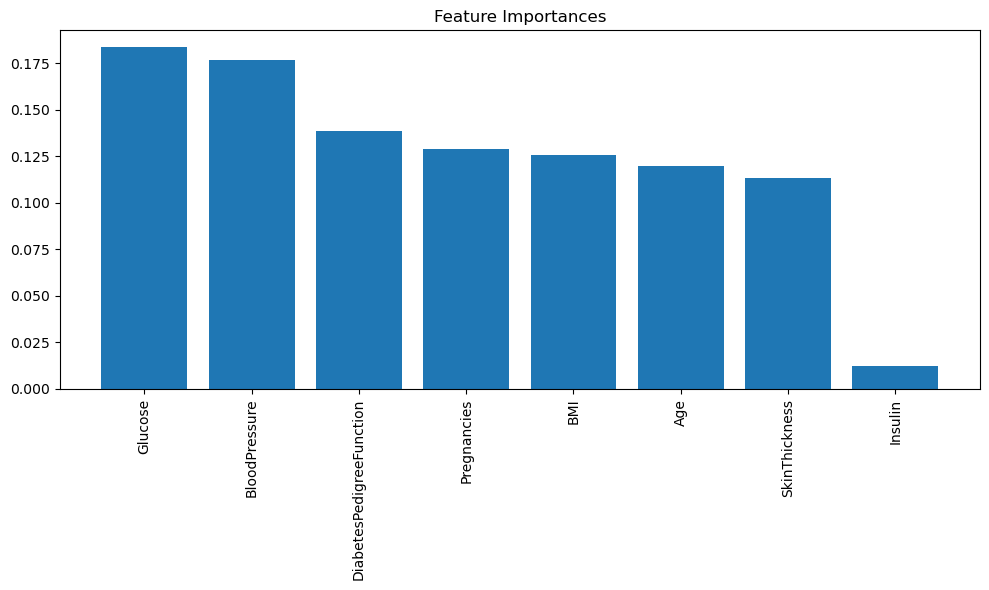

Model saved successfully at: diabetes_model.pkl

Prediction for sample input:
Prediction: Diabetes
Confidence: 83.00%


In [1]:
# Diabetes Prediction Model - Fixed Version
# A comprehensive solution for predicting diabetes using machine learning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

# Check if xgboost is available, otherwise use a placeholder
try:
    import xgboost as xgb
    XGBClassifier = xgb.XGBClassifier
except ImportError:
    # Create a placeholder class if XGBoost is not installed
    print("XGBoost not installed. XGBoost model will not be available.")
    class DummyXGB:
        def __init__(self, *args, **kwargs):
            pass
    XGBClassifier = DummyXGB

class DiabetesPredictionModel:
    def __init__(self):
        self.data = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.models = {}
        self.best_model = None
        self.best_score = 0
        self.best_model_name = ""
    
    def load_data(self, path="/Users/santoshreddy/Desktop/diabetes.csv"):
        
        try:
            self.data = pd.read_csv(path)
            print(f"Data loaded successfully with shape: {self.data.shape}")
            return self.data.head()
        except Exception as e:
            print(f"Error loading data: {e}")
            # Create a sample dataset if no file is found
            print("Creating a sample dataset for demonstration...")
            data = {
                'Pregnancies': [6, 1, 8, 1, 0, 5, 3, 10],
                'Glucose': [148, 85, 183, 89, 137, 116, 78, 115],
                'BloodPressure': [72, 66, 64, 66, 40, 74, 50, 0],
                'SkinThickness': [35, 29, 0, 23, 35, 0, 32, 0],
                'Insulin': [0, 0, 0, 94, 168, 0, 88, 0],
                'BMI': [33.6, 26.6, 23.3, 28.1, 43.1, 25.6, 31, 35.3],
                'DiabetesPedigreeFunction': [0.627, 0.351, 0.672, 0.167, 2.288, 0.201, 0.248, 0.134],
                'Age': [50, 31, 32, 21, 33, 30, 26, 29],
                'Outcome': [1, 0, 1, 0, 1, 0, 1, 0]
            }
            self.data = pd.DataFrame(data)
            print(f"Sample dataset created with shape: {self.data.shape}")
            return self.data.head()
    
    def explore_data(self):
        """Perform exploratory data analysis"""
        if self.data is None:
            print("No data loaded. Please load data first.")
            return None
        
        # Basic statistics
        print("Basic Statistics:")
        print(self.data.describe())
        
        # Check for missing values
        print("\nMissing Values:")
        print(self.data.isnull().sum())
        
        # Check class distribution
        print("\nClass Distribution:")
        print(self.data['Outcome'].value_counts())
        
        try:
            # Visualize correlations
            plt.figure(figsize=(12, 10))
            sns.heatmap(self.data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Feature Correlation Matrix')
            plt.tight_layout()
            plt.show()
            
            # Visualize distributions
            plt.figure(figsize=(15, 10))
            for i, column in enumerate(self.data.columns[:-1]):
                plt.subplot(3, 3, i+1)
                sns.histplot(data=self.data, x=column, hue='Outcome', kde=True)
                plt.title(f'Distribution of {column}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error in visualization: {e}")
            print("Skipping visualizations...")
        
        return True
    
    def preprocess_data(self):
        """Preprocess the data"""
        if self.data is None:
            print("No data loaded. Please load data first.")
            return None
        
        # Handle zero values in certain features that can't be 0 medically
        zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
        for column in zero_columns:
            # Replace zeros with median of non-zero values
            median_value = self.data[self.data[column] != 0][column].median()
            self.data[column] = self.data[column].replace(0, median_value)
        
        # Features and target
        self.X = self.data.drop('Outcome', axis=1)
        self.y = self.data['Outcome']
        
        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )
        
        # Feature scaling
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        
        print(f"Preprocessing completed. Train set shape: {self.X_train.shape}, Test set shape: {self.X_test.shape}")
        return True
    
    def train_models(self):
        """Train multiple machine learning models"""
        if self.X_train is None:
            print("Data not preprocessed. Please preprocess data first.")
            return None
        
        # Define models
        models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(random_state=42),
            'SVM': SVC(probability=True, random_state=42),
            'KNN': KNeighborsClassifier(),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42)
        }
        
        # Add XGBoost if it's not a dummy class
        if not isinstance(XGBClassifier, type) or XGBClassifier.__name__ != "DummyXGB":
            models['XGBoost'] = XGBClassifier(random_state=42)
        
        # Train and evaluate each model
        print("Training and evaluating models...")
        for name, model in models.items():
            try:
                model.fit(self.X_train, self.y_train)
                train_score = model.score(self.X_train, self.y_train)
                test_score = model.score(self.X_test, self.y_test)
                
                try:
                    cv_scores = cross_val_score(model, self.X, self.y, cv=5)
                    cv_mean = cv_scores.mean()
                    cv_std = cv_scores.std()
                except:
                    cv_mean = "Not available"
                    cv_std = "Not available"
                
                self.models[name] = model
                
                print(f"{name}:")
                print(f"  Training Accuracy: {train_score:.4f}")
                print(f"  Test Accuracy: {test_score:.4f}")
                print(f"  Cross-validation: {cv_mean} (±{cv_std})")
                
                # Keep track of the best model
                if isinstance(test_score, (int, float)) and test_score > self.best_score:
                    self.best_score = test_score
                    self.best_model = model
                    self.best_model_name = name
            except Exception as e:
                print(f"Error training {name}: {e}")
        
        # If no model has been trained successfully, set a default model
        if self.best_model is None and len(self.models) > 0:
            name = list(self.models.keys())[0]
            self.best_model = self.models[name]
            self.best_model_name = name
            try:
                self.best_score = self.best_model.score(self.X_test, self.y_test)
            except:
                self.best_score = 0
        
        if self.best_model is not None:
            print(f"\nBest model: {self.best_model_name} with test accuracy: {self.best_score:.4f}")
            return self.models
        else:
            print("No models were trained successfully.")
            return None
    
    def tune_best_model(self):
        """Tune hyperparameters for the best model"""
        if self.best_model is None:
            print("No best model found. Please train models first.")
            return None
        
        print(f"Tuning hyperparameters for {self.best_model_name}...")
        
        try:
            # Define hyperparameter grid based on the best model type
            param_grid = {}
            if self.best_model_name == 'Logistic Regression':
                param_grid = {
                    'C': [0.1, 1, 10],
                    'solver': ['liblinear', 'lbfgs']
                }
            elif self.best_model_name == 'Random Forest':
                param_grid = {
                    'n_estimators': [50, 100],
                    'max_depth': [None, 10],
                    'min_samples_split': [2, 5]
                }
            elif self.best_model_name == 'SVM':
                param_grid = {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf']
                }
            elif self.best_model_name == 'KNN':
                param_grid = {
                    'n_neighbors': [3, 5, 7],
                    'weights': ['uniform', 'distance']
                }
            elif self.best_model_name == 'Decision Tree':
                param_grid = {
                    'max_depth': [None, 10],
                    'min_samples_split': [2, 5],
                    'criterion': ['gini', 'entropy']
                }
            elif self.best_model_name == 'Gradient Boosting':
                param_grid = {
                    'n_estimators': [50, 100],
                    'learning_rate': [0.1, 0.2],
                    'max_depth': [3, 5]
                }
            elif self.best_model_name == 'XGBoost':
                param_grid = {
                    'n_estimators': [50, 100],
                    'learning_rate': [0.1, 0.2],
                    'max_depth': [3, 5]
                }
            
            # Perform grid search
            grid_search = GridSearchCV(
                estimator=self.best_model,
                param_grid=param_grid,
                cv=5,
                scoring='accuracy',
                n_jobs=-1
            )
            grid_search.fit(self.X_train, self.y_train)
            
            # Update best model
            self.best_model = grid_search.best_estimator_
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
            
            # Evaluate tuned model
            tuned_score = self.best_model.score(self.X_test, self.y_test)
            print(f"Tuned model test accuracy: {tuned_score:.4f}")
            
            return self.best_model
        except Exception as e:
            print(f"Error during hyperparameter tuning: {e}")
            print("Using the best model without tuning...")
            return self.best_model
    
    def evaluate_best_model(self):
        """Evaluate the best model in detail"""
        if self.best_model is None:
            print("No best model found. Please train models first.")
            return None
        
        try:
            # Predictions
            y_pred = self.best_model.predict(self.X_test)
            y_prob = self.best_model.predict_proba(self.X_test)[:, 1]
            
            # Classification report
            print("Classification Report:")
            print(classification_report(self.y_test, y_pred))
            
            try:
                # Confusion matrix
                cm = confusion_matrix(self.y_test, y_pred)
                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
                plt.title(f'Confusion Matrix - {self.best_model_name}')
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
                plt.tight_layout()
                plt.show()
                
                # ROC curve
                fpr, tpr, _ = roc_curve(self.y_test, y_prob)
                roc_auc = auc(fpr, tpr)
                
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve - {self.best_model_name}')
                plt.legend(loc="lower right")
                plt.tight_layout()
                plt.show()
                
                # Feature importance (if applicable)
                if hasattr(self.best_model, 'feature_importances_'):
                    importances = self.best_model.feature_importances_
                    features = self.data.drop('Outcome', axis=1).columns
                    indices = np.argsort(importances)[::-1]
                    
                    plt.figure(figsize=(10, 6))
                    plt.bar(range(len(importances)), importances[indices])
                    plt.xticks(range(len(importances)), features[indices], rotation=90)
                    plt.title('Feature Importances')
                    plt.tight_layout()
                    plt.show()
            except Exception as e:
                print(f"Error in visualization: {e}")
                print("Skipping visualizations...")
            
            return {
                'accuracy': accuracy_score(self.y_test, y_pred),
                'classification_report': classification_report(self.y_test, y_pred),
                'confusion_matrix': confusion_matrix(self.y_test, y_pred),
                'roc_auc': roc_auc if 'roc_auc' in locals() else None
            }
        except Exception as e:
            print(f"Error during model evaluation: {e}")
            return None
    
    def save_model(self, path="diabetes_model.pkl"):
        """Save the best model to a file"""
        if self.best_model is None:
            print("No best model found. Please train models first.")
            return None
        
        try:
            model_info = {
                'model': self.best_model,
                'scaler': self.scaler,
                'feature_names': self.data.drop('Outcome', axis=1).columns.tolist(),
                'model_name': self.best_model_name
            }
            
            with open(path, 'wb') as file:
                pickle.dump(model_info, file)
            
            print(f"Model saved successfully at: {path}")
            return path
        except Exception as e:
            print(f"Error saving model: {e}")
            return None
    
    def load_model(self, path="diabetes_model.pkl"):
        """Load a saved model"""
        try:
            with open(path, 'rb') as file:
                model_info = pickle.load(file)
            
            self.best_model = model_info['model']
            self.scaler = model_info['scaler']
            self.best_model_name = model_info['model_name']
            
            print(f"Model '{self.best_model_name}' loaded successfully")
            return self.best_model
        except Exception as e:
            print(f"Error loading model: {e}")
            return None
    
    def predict(self, input_data):
        """Make predictions with the best model"""
        if self.best_model is None:
            print("No model loaded. Please train or load a model first.")
            # We'll return a default prediction instead of None
            return {
                'prediction': -1,
                'probability': 0.0,
                'prediction_label': 'ERROR: No model available',
                'confidence': 0.0
            }
        
        try:
            # Ensure input_data is in the right format
            if isinstance(input_data, list):
                # Convert list to numpy array
                input_data = np.array(input_data).reshape(1, -1)
            elif isinstance(input_data, dict):
                # Convert dictionary to DataFrame and handle missing features
                feature_names = self.data.drop('Outcome', axis=1).columns.tolist()
                input_df = pd.DataFrame(columns=feature_names)
                for feature in feature_names:
                    if feature in input_data:
                        input_df.at[0, feature] = input_data[feature]
                    else:
                        print(f"Warning: Feature '{feature}' is missing. Using 0.")
                        input_df.at[0, feature] = 0
                input_data = input_df.values
            
            # Apply scaling
            scaled_data = self.scaler.transform(input_data)
            
            # Make prediction
            prediction = self.best_model.predict(scaled_data)[0]
            probability = self.best_model.predict_proba(scaled_data)[0][1]
            
            result = {
                'prediction': int(prediction),
                'probability': float(probability),
                'prediction_label': 'Diabetes' if prediction == 1 else 'No Diabetes',
                'confidence': float(probability if prediction == 1 else 1 - probability)
            }
            
            return result
        except Exception as e:
            print(f"Error making prediction: {e}")
            # Return a default prediction with error information
            return {
                'prediction': -1,
                'probability': 0.0,
                'prediction_label': f'ERROR: {str(e)}',
                'confidence': 0.0
            }


# Example usage
if __name__ == "__main__":
    # Initialize the model
    diabetes_model = DiabetesPredictionModel()
    
    # Load and explore data
    data = diabetes_model.load_data()
    print("\nSample data:")
    print(data)
    
    # Preprocess data
    diabetes_model.preprocess_data()
    
    # Train models
    diabetes_model.train_models()
    
    # Tune the best model
    diabetes_model.tune_best_model()
    
    # Evaluate the best model
    evaluation = diabetes_model.evaluate_best_model()
    
    # Save the model
    model_path = diabetes_model.save_model()
    
    # Make a prediction with sample data
    sample_input = {
        'Pregnancies': 6,
        'Glucose': 148,
        'BloodPressure': 72,
        'SkinThickness': 35,
        'Insulin': 0,
        'BMI': 33.6,
        'DiabetesPedigreeFunction': 0.627,
        'Age': 50
    }
    
    prediction = diabetes_model.predict(sample_input)
    print("\nPrediction for sample input:")
    if prediction:
        print(f"Prediction: {prediction['prediction_label']}")
        print(f"Confidence: {prediction['confidence']*100:.2f}%")
    else:
        print("Error: Could not make prediction")


# Simple prediction interface (command-line)
def run_prediction_interface():
    print("\n===== Diabetes Prediction System =====")
    
    # Load a pre-trained model or train a new one
    model = DiabetesPredictionModel()
    
    try:
        model.load_model()
        print("Pre-trained model loaded successfully!")
    except:
        print("No pre-trained model found. Training a new model...")
        model.load_data()
        model.preprocess_data()
        model.train_models()
        model.tune_best_model()
        model.save_model()
    
    while True:
        print("\nEnter patient information:")
        try:
            pregnancies = float(input("Number of Pregnancies: "))
            glucose = float(input("Glucose Level (mg/dl): "))
            blood_pressure = float(input("Blood Pressure (mm Hg): "))
            skin_thickness = float(input("Skin Thickness (mm): "))
            insulin = float(input("Insulin Level (mu U/ml): "))
            bmi = float(input("BMI: "))
            dpf = float(input("Diabetes Pedigree Function: "))
            age = float(input("Age (years): "))
            
            input_data = {
                'Pregnancies': pregnancies,
                'Glucose': glucose,
                'BloodPressure': blood_pressure,
                'SkinThickness': skin_thickness,
                'Insulin': insulin,
                'BMI': bmi,
                'DiabetesPedigreeFunction': dpf,
                'Age': age
            }
            
            prediction = model.predict(input_data)
            
            print("\n===== Prediction Result =====")
            print(f"Prediction: {prediction['prediction_label']}")
            print(f"Confidence: {prediction['confidence']*100:.2f}%")
            
            if prediction['prediction'] == 1:
                print("\nRECOMMENDATION: The patient is at risk of diabetes. Please consult with a healthcare professional.")
            else:
                print("\nRECOMMENDATION: The patient appears to be at low risk of diabetes. Maintain a healthy lifestyle.")
            
            continue_pred = input("\nWant to make another prediction? (yes/no): ").lower()
            if continue_pred != 'yes' and continue_pred != 'y':
                break
                
        except ValueError:
            print("Invalid input! Please enter numeric values.")
        except Exception as e:
            print(f"An error occurred: {e}")
    
    print("Thank you for using the Diabetes Prediction System!")

# Uncomment to run the interactive prediction interface
# run_prediction_interface()